Enter the min number of nodes: 2
Enter the max number of nodes: 3
Starting!
Elapsed time: 0 hours, 0 minutes, 0.14 seconds
0


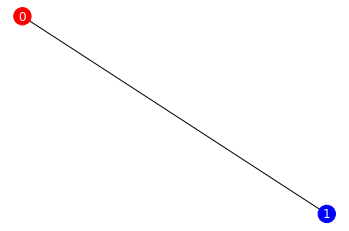

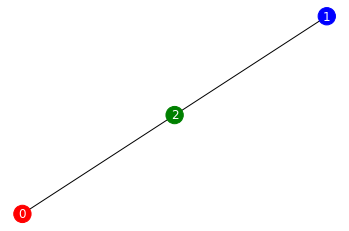

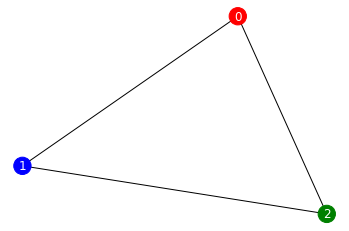

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import datetime
import os
import copy
import math
from concurrent.futures import ThreadPoolExecutor

writeToFile = True

foundGraphs = 0

currentGraphFile = 0

testInteger = 0
    
# For a memory cost, we can use this to avoid doing the checks twice for subgraphs when we remove nodes
criticalCache = {}

# This is to test the equality between the Graph6 keys and the str() function keys
testStrCache = {}

#We can also cache the Graph6 strings
graph6Cache = {}

#This is where we're saving the images to
imgDirectory = "images"


def removeSubstring(myStr, substring):
    output_string = ""
    str_list = myStr.split(substring)
    for element in str_list:
        output_string += element
    return output_string

def subdirectory(subdirectoryName, number):
    # Get the current directory path
    current_directory = os.path.dirname(os.path.abspath(__file__))


    # Create the subdirectory if it doesn't exist
    subdirectory_path = os.path.join(current_directory, subdirectoryName)
    os.makedirs(subdirectory_path, exist_ok=True)

    # Create the file within the subdirectory
    file_path = os.path.join(subdirectory_path, "classified graphs " + str(number) + ".txt")
    return file_path
    

def has_valid_coloring(adjacency_dict):

    # graph6DictString = graph_to_graph6_3(adjacency_dict)
    STRdictString = str(adjacency_dict)
    
    # getter = criticalCache.get(graph6DictString, None)
    getterStr = testStrCache.get(STRdictString, None)
    
    if (getterStr != None):
            # print(criticalCache[graph6DictString] == testStrCache[STRdictString])
            global testInteger
            testInteger = testInteger + 1
            return getterStr

    # Determine the maximum degree of any node in the graph
    node_degrees = [len(neighbors) for neighbors in adjacency_dict.values()]
    
    if (len(node_degrees) == 0):
        cache[dictString] = 0
        return 0
    
    max_degree = max(node_degrees)

    # Define a function that recursively tries all possible colorings
    def try_coloring(coloring, node_order):
        # If all nodes have been colored, check if the coloring is valid
        if len(coloring) == len(adjacency_dict):
            for node, neighbors in adjacency_dict.items():
                for neighbor in neighbors:
                    
                    # Normally this check isn't needed, but we need it when we remove nodes from the dictionary
                    # Of course, we need to remove nodes to check if a graph is critical
                    dictNode = coloring.get(node, None)
                    dictNeighbor = coloring.get(neighbor, None)
                    
                    if (dictNode != None and dictNeighbor != None):
                        if dictNode == dictNeighbor:
                            return 0
            
            max_color = max(coloring[node] for node in adjacency_dict.keys())

            # Return the maximum color
            return max_color

        # Otherwise, recursively try all possible color assignments for the next node
        next_node = node_order[len(coloring)]
        neighborhood = adjacency_dict[next_node]
        
        for color in range(max_degree + 1):
            if all(color != coloring.get(neighbor, None) for neighbor in neighborhood):
                coloring[next_node] = color
                
                max_color = try_coloring(coloring, node_order)
                
                if (max_color != 0):
                    # Return the maximum color
                    return max_color
        return 0

    # Generate a list of nodes ordered by degree (highest first)
    nodes = list(adjacency_dict.keys())
    node_order = sorted(nodes, key=lambda node: -len(adjacency_dict[node]))

    # Try all possible colorings starting with an empty coloring
    colors = list(range(max_degree + 1))
    chi = try_coloring({}, node_order)
    # criticalCache[graph6DictString] = chi
    testStrCache[STRdictString] = chi
    # print(cache[dictString])
    return chi + 1

def adjacencyDict(edges):
        # Build a dictionary where each edge is a key and its value is a set of neighboring edges
    adjacency_dict = {}
    for edge in edges:
        if edge[0] not in adjacency_dict:
            adjacency_dict[edge[0]] = set()
        if edge[1] not in adjacency_dict:
            adjacency_dict[edge[1]] = set()
        adjacency_dict[edge[0]].add(edge[1])
        adjacency_dict[edge[1]].add(edge[0])
    
    #print(adjacency_dict)
    return adjacency_dict

def remove_node(adj_dict, node):
    # create a copy of the adjacency dictionary to modify
    new_adj_dict = copy.deepcopy(adj_dict)

    # remove the node and its edges from the dictionary
    
    #This takes care of the node
    del new_adj_dict[node]
    
    #This loops through the edges
    for neighbor in adj_dict[node]:
        
        getter = new_adj_dict.get(neighbor, None)
        if (getter != None) :
            if (node in new_adj_dict[neighbor]):
                new_adj_dict[neighbor].remove(node)
    # del new_adj_dict[node]

  # shift down the node indices higher than the removed node
    for i in range(node+1, max(new_adj_dict)+1):
        if i in new_adj_dict:
            new_adj_dict[i-1] = new_adj_dict.pop(i)
            new_adj_dict[i-1] = {j-1 if j>node else j for j in new_adj_dict[i-1]}
  

    return new_adj_dict

#This returns whether a graph has a subgraph of P_5 anywhere
def isP5Free(graph):
    
    #Permute through the possible start and end points
    #The order doesn't matter
    for start in range(len(graph.nodes())):
        for end in range(start, len(graph.nodes())):
            
            #paths = nx.all_simple_paths(graph, start, end)
            
            #Set this to something arbitrairly large to start
            #minLength = 100000
            
            #for path in paths:
                
                #currentPathLen = len(path)
                
                #if (currentPathLen < minLength):
                    #minLength = pathLen
                    
                #if (minLength < 5):
                    #break
                
            path = nx.shortest_path(graph, start, end)
            
            if (len(path) >= 5):
                    return False
    
    #The graph has passed all the tests
    return True

def graph_to_graph6_3(adj_dict):
    
    dictString = str(adj_dict)
    
    #This cache can get big, so we only do it for small graphs
    if (len(adj_dict) <= 5):
        getter = graph6Cache.get(dictString, None)
        if (getter != None):
                return getter
    
    # Create a graph object from the adjacency dictionary
    G = nx.Graph(adj_dict)

    # Obtain a Graph6 string from the graph object
    graph6 = nx.to_graph6_bytes(G).decode('ascii')

    # Remove the newline character at the end of the string
    graph6 = graph6.rstrip('\n')
    
    if (len(adj_dict) <= 5):
        graph6Cache[dictString] = graph6
    
    return graph6

def drawFigureGraph(G, fig):

                        
    color_array = ["red", "blue", "green", "gold", "orange", "purple", "teal", "black", "grey", "steelblue", "magenta", "violet", "dodgerblue", "brown"]
    color_array_trunc = []
    
    for i in range(len(G.nodes())):
        color_array_trunc.append(color_array[i])
        
    # Create a dictionary that maps each node to its color
    # color_map = {node: color_array[coloring[node]] for node in adjacency_dict.keys()}

    # Draw the colored graph using networkx
    nx.draw(G, with_labels=True, node_color=color_array_trunc, font_color='w', ax=fig.add_subplot(111))

def drawGraph(dict_):
    print(dict_)
    
    G = nx.Graph(dict_)
                        
    color_array = ["red", "blue", "green", "gold", "orange", "purple", "teal", "black", "grey", "steelblue", "magenta", "violet", "dodgerblue", "brown"]
    color_array_trunc = []
    
    for i in range(len(dict_)):
        color_array_trunc.append(color_array[i])
        
    # Create a dictionary that maps each node to its color
    # color_map = {node: color_array[coloring[node]] for node in adjacency_dict.keys()}

    # Draw the colored graph using networkx
    nx.draw(G, with_labels=True, node_color=color_array_trunc, font_color='w')

def showGraph(dict_):
    drawGraph(dict_)
    plt.show()

def classifyGraph(graph):
  
    if (isP5Free(graph)):
        # print("Critical graph found!")
        return [True, graph]
    
    return [False, graph]


def multithreading(min_nodes, max_nodes, num_threads):

    global imgDirectory
    if (not os.path.exists(imgDirectory)):
        os.makedirs(imgDirectory)
    
    # Create a thread pool executor with the specified number of threads

    with ThreadPoolExecutor(max_workers=num_threads) as executor:

        # Submit each number to the executor for processing

        futures = []

        for num_nodes in range(min_nodes, max_nodes+1):
            nauty_generator = graphs.nauty_geng(str(num_nodes) + " -c")
            graphs_list = list(nauty_generator)

            for g in graphs_list:
                #g.show()
                networkx_graph = g.networkx_graph()
                futures.append(executor.submit(foo,networkx_graph))

        # Get the results from each future as they become available

        results = [future.result() for future in futures]
        
        for r in results:
            foo2(r)
            
    return


def foo(graph):

    # This array has True in index 0 if the graph is P5-free
    # It ha a print message in index 1
    # The graph itself is in index 2
    graphResults = classifyGraph(graph)
    return graphResults


                    

def foo2(graphResults):

    global currentGraphFile
    global outputStream
    global imgDirectory
    
    if (graphResults[0]):

        
        edges = graphResults[1].edges()
        adj_dict = adjacencyDict(edges)
        
        graph6Str = graph_to_graph6_3(adj_dict)
        graph6Str = removeSubstring(graph6Str, ">>graph6<<")

        global writeToFile
        if (writeToFile):
            #Save the graph image
            path = os.path.join(imgDirectory, f"graph_{currentGraphFile}.png")
            figure = plt.figure()
            drawFigureGraph(graphResults[1], figure)
            plt.savefig(path)
        
            currentGraphFile = currentGraphFile + 1

        #print(edges)
        # print(graphResults[1])
        # showGraph(adj_dict)
    

# Example usage

min_nodes = int(input("Enter the min number of nodes: "))
max_nodes = int(input("Enter the max number of nodes: "))



print("Starting!")
start_time = datetime.datetime.now()

multithreading(min_nodes, max_nodes, 3)

end_time = datetime.datetime.now()

elapsed_time = end_time - start_time
totalSeconds = elapsed_time.total_seconds()



hours, remainder = divmod(int(totalSeconds), 3600)
minutes, seconds = divmod(remainder, 60)
roundSeconds = float("{:.2f}".format(math.modf(totalSeconds)[0] + seconds))

print("Elapsed time: {} hours, {} minutes, {} seconds".format(int(hours), int(minutes), roundSeconds))
print(testInteger)